In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt
import glob

In [110]:
def parse_tfrecord(example_proto):
    """Parse TFRecord example and resize image for ResNet50."""
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64)
    }
    
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode and resize image
    image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)
    
    # Get original dimensions
    orig_height = tf.cast(tf.shape(image)[0], tf.float32)
    orig_width = tf.cast(tf.shape(image)[1], tf.float32)
    
    # Resize image to 224x224
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    
    # Ensure image has correct shape
    image = tf.ensure_shape(image, [224, 224, 3])
    
    # Scale bounding box coordinates
    height_scale = 224.0 / orig_height
    width_scale = 224.0 / orig_width
    
    xmin = parsed_features['image/object/bbox/xmin'].values * width_scale
    xmax = parsed_features['image/object/bbox/xmax'].values * width_scale
    ymin = parsed_features['image/object/bbox/ymin'].values * height_scale
    ymax = parsed_features['image/object/bbox/ymax'].values * height_scale
    
    # Stack boxes
    boxes = tf.stack([ymin, xmin, ymax, xmax], axis=1)
    labels = parsed_features['image/object/class/label'].values
    
    # Pad boxes and labels
    padded_boxes = tf.pad(boxes, [[0, 100 - tf.shape(boxes)[0]], [0, 0]], constant_values=-1)
    padded_labels = tf.pad(labels, [[0, 100 - tf.shape(labels)[0]]], constant_values=41)
    
    return image, {
        'boxes': padded_boxes,
        'labels': padded_labels
    }

# Load datasets
train_files = glob.glob("Firefighting Device Detection.v6i.tfrecord/train/*.tfrecord")
val_files = glob.glob("Firefighting Device Detection.v6i.tfrecord/valid/*.tfrecord")

# Create datasets with correct shapes
BATCH_SIZE = 32
train_dataset = (tf.data.TFRecordDataset(train_files)
                .map(parse_tfrecord)
                .batch(BATCH_SIZE)
                # .repeat()
                .prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.TFRecordDataset(val_files)
              .map(parse_tfrecord)
              .batch(BATCH_SIZE)
            #   .repeat()
              .prefetch(tf.data.AUTOTUNE))

# Check the dataset shapes
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)  # Should be (batch_size, 224, 224, 3)
    print("Boxes shape:", labels['boxes'].shape)
    print("Labels shape:", labels['labels'].shape)

Batch shape: (32, 224, 224, 3)
Boxes shape: (32, 100, 4)
Labels shape: (32, 100)


In [111]:
NUM_CLASSES = 42
MAX_OBJECTS = 100

# Create custom reshape layers
class ReshapeBoxes(tf.keras.layers.Layer):
    def call(self, x):
        return tf.reshape(x, [-1, MAX_OBJECTS, 4])

class ReshapeClasses(tf.keras.layers.Layer):
    def call(self, x):
        return tf.reshape(x, [-1, MAX_OBJECTS, NUM_CLASSES])

# Custom loss function for bboxes to handle variable number of objects
def variable_objects_loss(y_true, y_pred, mask_value=-1):
    # Create mask for valid objects (assuming -1 indicates no object)
    mask = tf.not_equal(y_true, mask_value)
    mask = tf.cast(mask, y_true.dtype)
    
    # Apply mask to both true and predicted values
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask
    
    # Calculate loss only on valid objects
    return tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))

# Custom loss function for classification
def masked_sparse_categorical_crossentropy(y_true, y_pred, mask_value=-1):
    # Create mask for valid labels (not -1)
    mask = tf.not_equal(y_true, mask_value)
    mask = tf.cast(mask, tf.float32)
    
    # Get number of valid entries
    valid_entries = tf.reduce_sum(mask)
    
    # Calculate regular sparse categorical crossentropy
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred, from_logits=True)
    
    # Apply mask and normalize by number of valid entries
    masked_loss = loss * mask
    return tf.reduce_sum(masked_loss) / (valid_entries + tf.keras.backend.epsilon())

In [ ]:
class DetectionModel(tf.keras.Model):
    def __init__(self):
        super(DetectionModel, self).__init__()
        # Load pretrained SimCLR model as backbone
        self.backbone = tf.saved_model.load('checkpoint_dir')
        
        # Detection heads
        self.bbox_head = tf.keras.Sequential([
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(MAX_OBJECTS * 4),
            ReshapeBoxes()
        ], name='bbox_head')

        self.class_head = tf.keras.Sequential([
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(MAX_OBJECTS * NUM_CLASSES),
            ReshapeClasses()
        ], name='class_head')

    def call(self, inputs):
        # Get features from frozen SimCLR backbone
        features = self.backbone(inputs, trainable=False)
        features = features['block_group4']  # Shape: (batch_size, 7, 7, 2048)
        
        # Pass through detection heads
        boxes = self.bbox_head(features)
        classes = self.class_head(features)
        
        return {
            'boxes': boxes,
            'labels': classes
        }

# Create and compile model
detection_model = DetectionModel()
detection_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'boxes': variable_objects_loss,
        'labels': masked_sparse_categorical_crossentropy
    }
)

In [114]:
# Fine-tune with different hyperparameters
print("\nStarting detection fine-tuning experiments...")

# Experiment 1: Baseline
print("\nExperiment 1: Baseline")
history1 = detection_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=len(train_files) // BATCH_SIZE,
    validation_steps=len(val_files) // BATCH_SIZE
)
detection_model.save('firefighting_detector_baseline.keras')

# Experiment 2: Larger batch size
print("\nExperiment 2: Larger batch size")
BATCH_SIZE = 64
train_dataset_large = train_dataset.unbatch().batch(BATCH_SIZE)
val_dataset_large = val_dataset.unbatch().batch(BATCH_SIZE)

history2 = detection_model.fit(
    train_dataset_large,
    validation_data=val_dataset_large,
    epochs=5,
    steps_per_epoch=len(train_files) // BATCH_SIZE,
    validation_steps=len(val_files) // BATCH_SIZE
)
detection_model.save('firefighting_detector_large_batch.keras')

# Experiment 3: Different learning rate
print("\nExperiment 3: Lower learning rate")
BATCH_SIZE = 32
detection_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss={
        'boxes': variable_objects_loss,
        'labels': masked_sparse_categorical_crossentropy
    }
)
history3 = detection_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=len(train_files) // BATCH_SIZE,
    validation_steps=len(val_files) // BATCH_SIZE
)
detection_model.save('firefighting_detector_low_lr.keras')


Starting detection fine-tuning experiments...

Experiment 1: Baseline
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - boxes_loss: 0.0037 - labels_loss: 2.7810 - loss: 2.9037 - val_boxes_loss: 0.0022 - val_labels_loss: 1.4221 - val_loss: 2.8486
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - boxes_loss: 0.0037 - labels_loss: 2.7239 - loss: 2.8444 - val_boxes_loss: 0.0022 - val_labels_loss: 1.3907 - val_loss: 2.7857
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - boxes_loss: 0.0036 - labels_loss: 2.6624 - loss: 2.7806 - val_boxes_loss: 0.0022 - val_labels_loss: 1.3570 - val_loss: 2.7184
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - boxes_loss: 0.0036 - labels_loss: 2.5965 - loss: 2.7120 - val_boxes_loss: 0.0021 - val_labels_loss: 1.3212 - val_loss: 2.6466
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - boxes_loss: 0.0035 - labels_loss: 2.5261 - loss: 2.6389 - val_boxes_loss: 0.0021 - val_labels_loss: 1.2832 - val_loss: 2.5706

Experiment 2: Larger batch size
Epoch 1/5
2/2 ━━━━━━━━━━

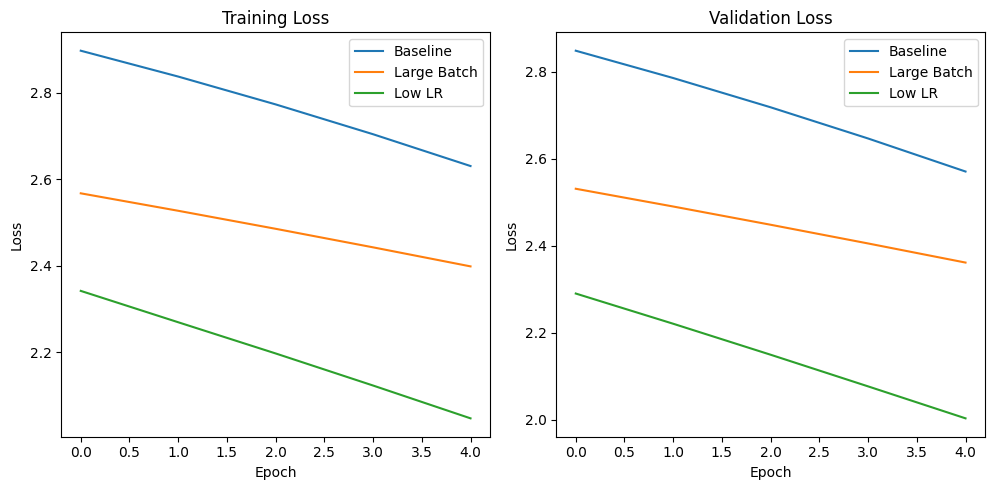

In [115]:
# Plot results
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(history1.history['loss'], label='Baseline')
plt.plot(history2.history['loss'], label='Large Batch')
plt.plot(history3.history['loss'], label='Low LR')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 3, 2)
plt.plot(history1.history['val_loss'], label='Baseline')
plt.plot(history2.history['val_loss'], label='Large Batch')
plt.plot(history3.history['val_loss'], label='Low LR')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()